In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm

from scipy.signal import correlate
from scipy.interpolate import griddata
from scipy.signal import correlate2d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.ndimage import shift
from sklearn.preprocessing import MinMaxScaler

from ezyrb import POD, RBF, Database, Snapshot, Parameter
from ezyrb import ReducedOrderModel as ROM

In [3]:
params = np.load('vortex_data/time_covo.npy').reshape(-1,1)
snapshots = np.load('vortex_data/density_covo.npy').T 
points = np.load('vortex_data/points_covo.npy') 
space = points   # x and y coordinates discretized domain

min_val = np.min(snapshots)
max_val = np.max(snapshots)
scaled = (snapshots - min_val) / (max_val - min_val)
rescaled_snapshots = scaled * (max_val - min_val) + min_val
scaled_snapshots = scaled

x = space[:,0]
y = space[:,1]

pod = POD(rank=1)  
rbf = RBF()
db = Database()

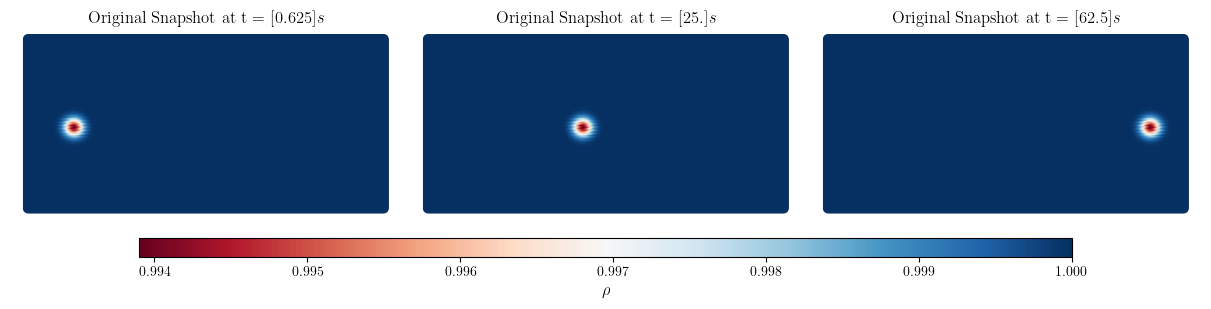

In [4]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "font.size": 10,
})

param_id = np.array((1, 40, snapshots.shape[1] - 1))
fig, axes = plt.subplots(1, 3, figsize=(12, 3), constrained_layout=True)
for i, pid in enumerate(param_id):
    sc = axes[i].scatter(space[:, 0], space[:, 1], c=snapshots[:, pid], marker='o', cmap='RdBu')
    axes[i].set_title(r"$\mathrm{Original\ Snapshot\ at\  t=\ }$" + f"${params[pid]}s$ ", fontsize=12)
    axes[i].axis('off')
    axes[i].set_xlabel('X', fontsize=10)
    axes[i].set_ylabel('Y', fontsize=10)
cbar = fig.colorbar(sc, ax=axes.ravel().tolist(), orientation='horizontal', fraction=0.1, pad=0.1, aspect=50)
cbar.set_label(r'$\rho$', fontsize=12)
plt.show()

In [5]:
# Splitting training and test set
n_params = len(params)
train_end = int(0.3 * n_params)             
test_end = int(0.7 * n_params)             
train_params = params[:train_end]          
test_params = params[train_end:]            

db_train = Database()
db_test = Database()

for i, param in enumerate(train_params):
    values = scaled_snapshots[:, i]
    snap = Snapshot(values=values.T, space=space)
    db_train.add(Parameter(param), snap)

for i, param in enumerate(test_params):
    values = scaled_snapshots[:, train_end + i]
    snap = Snapshot(values=values.T, space=space)
    db_test.add(Parameter(param), snap)

In [6]:
shifts = []
reference_density = db_train.snapshots_matrix[0]  

registered_densities = []
for i, density in enumerate(db_train.snapshots_matrix):
    reference_row = reference_density.flatten()  
    density_row = density.flatten()
    # Calculate the optimal shift using cross-correlation between the reference wave and the training snapshots
    corr_x = correlate(reference_row, density_row, mode='full')
    shift_x = np.argmax(corr_x) - len(reference_row) + 1                # Shift in x direction
    shifts.append((shift_x)) 
    registered_density = shift(density, shift=(shift_x,), mode='nearest')  # Shift only in x direction
    registered_densities.append(registered_density)
shifts = np.array(shifts)

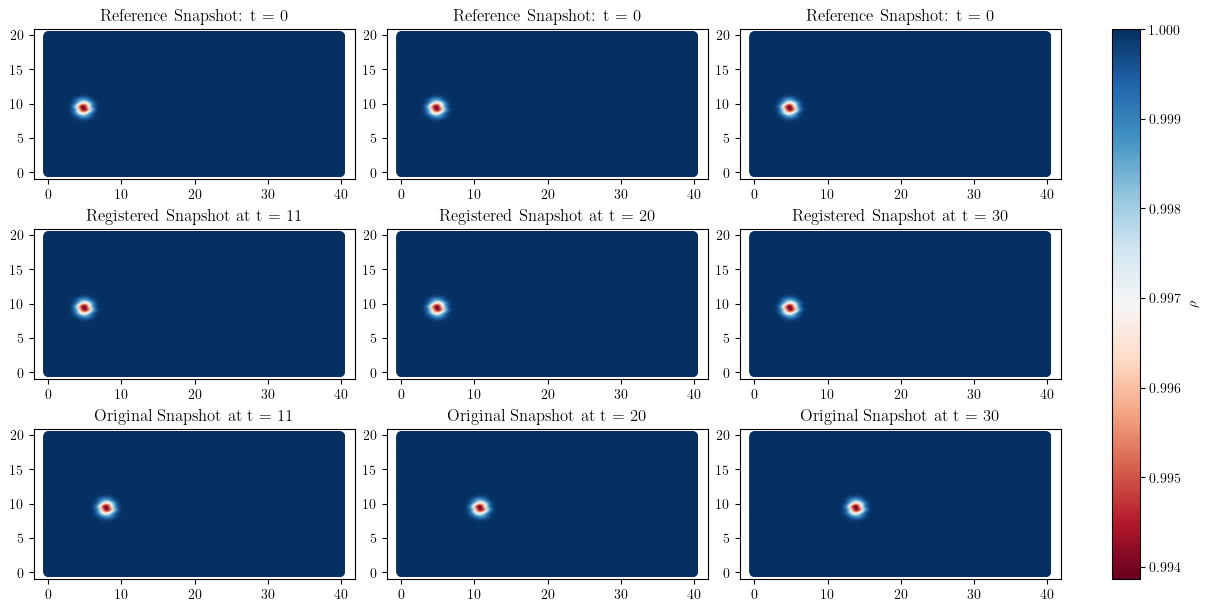

In [7]:
indices = [10, 19, 29]
fig, axes = plt.subplots(3, 3, figsize=(12, 6), constrained_layout=True)
sc_plots = []
for col, index in enumerate(indices):
    reference_rescaled = reference_density * (max_val - min_val) + min_val
    registered_rescaled = registered_densities[index] * (max_val - min_val) + min_val
    snapshot_rescaled = snapshots[:, index] * (max_val - min_val) + min_val
    
    ax = axes[0, col]  
    sc = ax.scatter(x, y, c=reference_rescaled, cmap='RdBu')
    ax.set_title(f'Reference Snapshot: t = 0')
    sc_plots.append(sc) 

    ax = axes[1, col]  
    sc = ax.scatter(x, y, c=registered_rescaled, cmap='RdBu')    
    ax.set_title(f'Registered Snapshot at t = {index + 1}')
    sc_plots.append(sc)  

    ax = axes[2, col]  
    sc = ax.scatter(x, y, c=snapshot_rescaled, cmap='RdBu')
    ax.set_title(f'Original Snapshot at t = {index + 1}')
    sc_plots.append(sc) 
fig.colorbar(sc_plots[0], ax=axes.ravel().tolist(), orientation='vertical',  label=r'$\rho$')
plt.show()

In [8]:
registered_train_db = Database()

for i, param in enumerate(db_train.parameters_matrix):
    registered_values = registered_densities[i]                           # Get the registered wave corresponding to the parameter
    align = Snapshot(values=registered_values, space=space)
    registered_train_db.add(Parameter(param), align)
    
print("registered Train Snapshot shape : ", registered_train_db.snapshots_matrix.shape)
print("registered Parameter shape : ", registered_train_db.parameters_matrix.shape)

registered Train Snapshot shape :  (30, 28800)
registered Parameter shape :  (30, 1)


In [9]:
#%% Construct ROM
rom = ROM(database=registered_train_db, reduction=pod, approximation=rbf)
rom.fit()

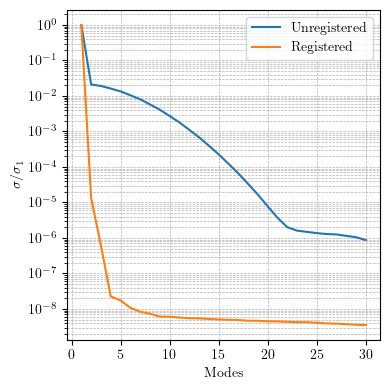

In [10]:
U, s = np.linalg.svd(db_train.snapshots_matrix.T, full_matrices=False)[:2]
N_modes = np.linspace(1, len(s),len(s))

registered_rescaled = registered_train_db.snapshots_matrix * (max_val - min_val) + min_val
U_shifted , s_shifted = np.linalg.svd(registered_rescaled.T, full_matrices=False)[:2]
N_modes_shifted = np.linspace(1, len(s_shifted),len(s_shifted))
plt.figure(figsize=(4,4))
plt.plot(N_modes, s/np.max(s), label='Unregistered')
plt.plot(N_modes_shifted, s_shifted/np.max(s_shifted),label='Registered')
plt.ylabel(r'$ \sigma/\sigma_{1}$')
plt.xlabel('Modes')
plt.legend()
plt.yscale('log')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

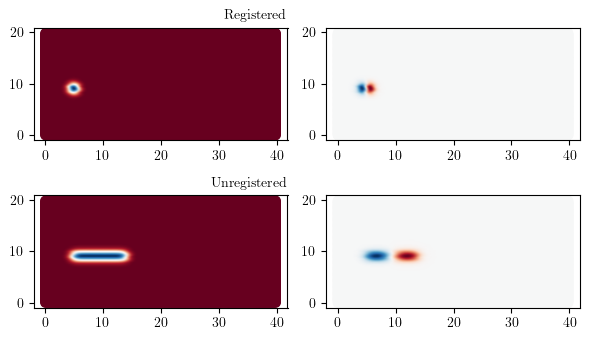

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3.5))  
axs[0, 0].scatter(x, y, c=U_shifted[:, 0], cmap='RdBu')  
axs[0, 1].scatter(x, y, c=U_shifted[:, 1], cmap='RdBu')  

axs[1, 0].scatter(x, y, c=U[:, 0], cmap='RdBu')  
axs[1, 1].scatter(x, y, c=U[:, 1], cmap='RdBu')  

axs[0, 0].set_title('Registered', fontsize=10, loc='right')  
axs[1, 0].set_title('Unregistered', fontsize=10, loc='right')  
plt.tight_layout()
plt.show()

In [12]:
X = db_train.parameters_matrix.reshape(-1, 1)
Y = np.array(shifts)  # Shifts

# Fit polynomial regression model
degree = 1    # polynomial degree
poly_features = PolynomialFeatures(degree=degree)
X_poly = poly_features.fit_transform(X)

# Linear regression model
model = LinearRegression()
model.fit(X_poly, Y)

# Predict shifts for new parameters
def predict_shift(parameter):
    param_poly = poly_features.transform(np.array([[parameter]]))
    predicted_shift = model.predict(param_poly)
    return predicted_shift[0]

In [13]:
test_params = test_params.flatten()

predicted_shifts = []
for param in test_params:
    predicted_shift = predict_shift(param)
    predicted_shifts.append(predicted_shift)

In [14]:
#%% Predictions for test set parmeters
predict_test = rom.predict(db_test.parameters_matrix)

def revert_wave(registered_densities, predicted_shifts):
    restored_densities = []
    
    for i, registered_density in enumerate(registered_densities):
        shift_x = predicted_shifts[i]  
        restored_density = shift(registered_density, shift=(-shift_x,), mode='nearest')  # Negative shift to revert the densities to original position. 
        restored_densities.append(restored_density)    
    return restored_densities
restored_densities = revert_wave(predict_test.snapshots_matrix, predicted_shifts)
restored_densities = np.array(restored_densities)

In [15]:
pred_test_snapshots_rescaled = []
test_snapshots_rescaled = []

for i in range(len(db_test)):
    predict = restored_densities[i]
    predict_rescaled_snap = predict  * (max_val - min_val) + min_val
    pred_test_snapshots_rescaled.append(predict_rescaled_snap)
    
pred_test_snapshots_rescaled = np.array(pred_test_snapshots_rescaled)

for i in range(len(db_test)):
    db_rescaled_test_snap = db_test.snapshots_matrix[i] * (max_val - min_val) + min_val
    test_snapshots_rescaled.append(db_rescaled_test_snap)

test_snapshots_rescaled = np.array(test_snapshots_rescaled)

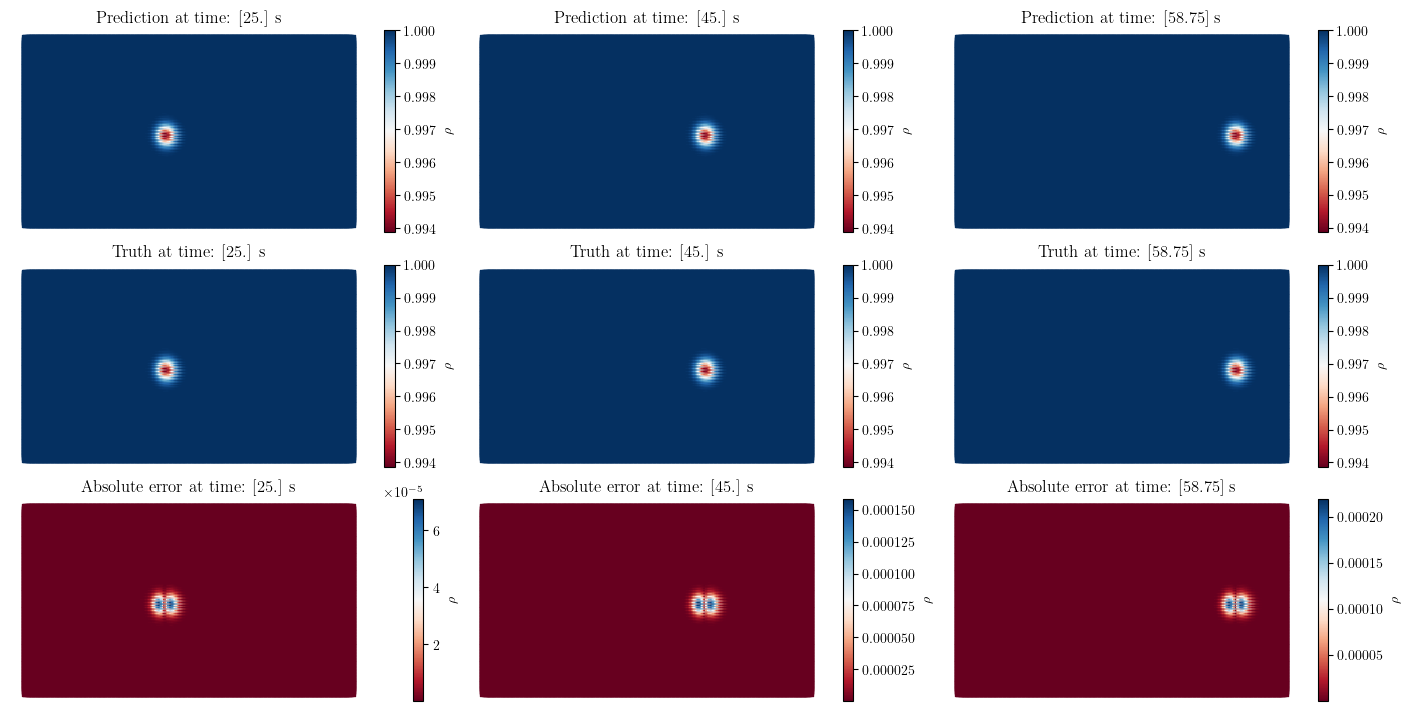

In [16]:
test_ids = np.array([10, 42, 64])

fig, axes = plt.subplots(3, 3, figsize=(14, 7), constrained_layout=True)
for col, test_id in enumerate(test_ids):    
    diff = np.abs(test_snapshots_rescaled[test_id].flatten() - pred_test_snapshots_rescaled[test_id].flatten())
    
    # Prediction (top row)
    ax1 = axes[0, col]
    sc1 = ax1.scatter(space[:, 0], space[:, 1], c=pred_test_snapshots_rescaled[test_id], cmap='RdBu', marker=',')
    ax1.set_title(f"Prediction at time: {db_test.parameters_matrix[test_id]} s")
    ax1.axis("off")
    fig.colorbar(sc1, ax=ax1, orientation='vertical', label=r'$\rho$')

    # Truth (middle row)
    ax2 = axes[1, col]
    sc2 = ax2.scatter(space[:, 0], space[:, 1], c=test_snapshots_rescaled[test_id], cmap='RdBu', marker=',')
    ax2.set_title(f"Truth at time: {db_test.parameters_matrix[test_id]} s")
    ax2.axis("off")
    fig.colorbar(sc2, ax=ax2, orientation='vertical', label=r'$\rho$')

    # Absolute error (bottom row)
    ax3 = axes[2, col]
    sc3 = ax3.scatter(space[:, 0], space[:, 1], c=diff, cmap='RdBu', marker=',')
    ax3.set_title(f"Absolute error at time: {db_test.parameters_matrix[test_id]} s")
    ax3.axis("off")
    fig.colorbar(sc3, ax=ax3, orientation='vertical', label=r'$\rho$')
plt.show()

In [17]:
# Calculate relative L2 norm as percentages for each snapshot
relative_l2_norms_percentage = []

for i in range(len(db_test.snapshots_matrix)):
    diff_norm = norm(restored_densities[i] - db_test.snapshots_matrix[i])
    original_norm = norm(db_test.snapshots_matrix[i])
    relative_l2_percentage = (diff_norm / original_norm)
    relative_l2_norms_percentage.append(relative_l2_percentage)

test_parameters = db_test.parameters_matrix.flatten()

In [18]:
# Predictions for training set parameters
predict_train = rom.predict(db_train.parameters_matrix)

# Predict shifts for training set
predicted_shifts_train = []
for param in db_train.parameters_matrix.flatten():
    predicted_shift = predict_shift(param)
    predicted_shifts_train.append(predicted_shift)

predicted_shifts_train = np.array(predicted_shifts_train)

restored_densities_train = revert_wave(predict_train.snapshots_matrix, predicted_shifts_train)
restored_densities_train = np.array(restored_densities_train)

In [19]:
pred_train_snapshots_rescaled = []
train_snapshots_rescaled = []

for i in range(len(db_train)):
    predict_rescaled_snap = restored_densities_train[i] * (max_val - min_val) + min_val
    pred_train_snapshots_rescaled.append(predict_rescaled_snap)
pred_train_snapshots_rescaled = np.array(pred_train_snapshots_rescaled)

for i in range(len(db_train)):
    db_rescaled_train_snap = db_train.snapshots_matrix[i] * (max_val - min_val) + min_val
    train_snapshots_rescaled.append(db_rescaled_train_snap)
train_snapshots_rescaled = np.array(train_snapshots_rescaled)

In [20]:
relative_l2_norms_train_percentage = []

for i in range(len(db_train.snapshots_matrix)):
    diff_norm = norm(restored_densities_train[i] - db_train.snapshots_matrix[i])
    original_norm = norm(db_train.snapshots_matrix[i])
    relative_l2_percentage = (diff_norm / original_norm)
    relative_l2_norms_train_percentage.append(relative_l2_percentage)

train_parameters = db_train.parameters_matrix.flatten()

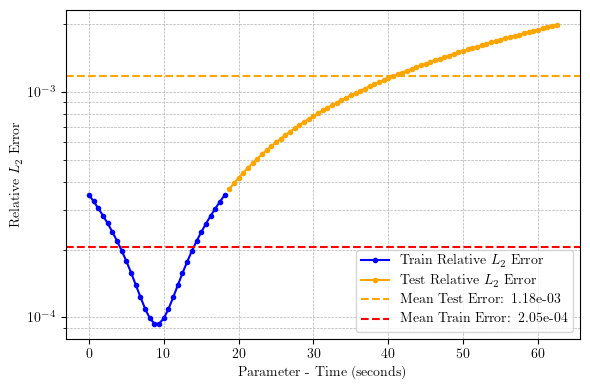

In [21]:
train_parameters = db_train.parameters_matrix.flatten()
test_parameters = db_test.parameters_matrix.flatten()

pred_val_mean = np.mean(relative_l2_norms_percentage)
pred_train_mean = np.mean(relative_l2_norms_train_percentage)

plt.figure(figsize=(6, 4))
plt.plot(train_parameters, relative_l2_norms_train_percentage, marker='.', linestyle='-', color='b', label=r'Train Relative $L_2$ Error')
plt.plot(test_parameters, relative_l2_norms_percentage, marker='.', linestyle='-', color='orange', label=r'Test Relative $L_2$ Error')
plt.axhline(pred_val_mean, color='orange', linestyle='--', label=f'Mean Test Error: {pred_val_mean:.2e}')
plt.axhline(pred_train_mean, color='r', linestyle='--', label=f'Mean Train Error: {pred_train_mean:.2e}')
plt.xlabel('Parameter - Time (seconds)')
plt.ylabel(r'Relative $L_2$ Error ')
plt.yscale('log') 
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [22]:
# Prediction errors for varying standard POD rank, for unregistered snapshots
pod_ranks = [1, 2, 4, 8, 10, 16, 20, 25]
mean_train_errors = []
mean_test_errors = []

for rank in pod_ranks:
    standard_pod = POD(rank=rank)
    rbf = RBF()
    pod_rbf_rom = ROM(database=db_train, reduction=standard_pod, approximation=rbf)
    pod_rbf_rom.fit()

    train_err = pod_rbf_rom.test_error(db_train)
    test_err = pod_rbf_rom.test_error(db_test)
    
    mean_train_errors.append(train_err)
    mean_test_errors.append(test_err)

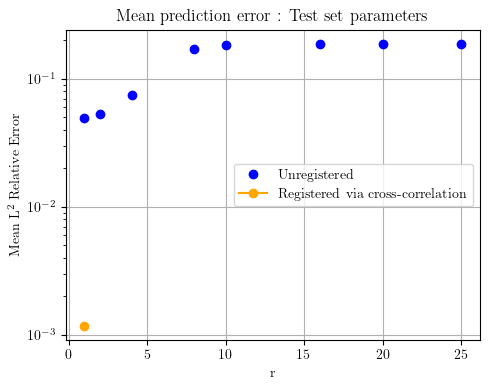

In [23]:
plt.figure(figsize=(5,4))
plt.plot(pod_ranks, mean_test_errors, marker='o', linestyle='', color='b', label='Unregistered')
plt.plot(1, pred_val_mean, marker='o', linestyle='-', color='orange', label = "Registered via cross-correlation")
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('Mean L$^2$ Relative Error')
plt.title("Mean prediction error : Test set parameters")
plt.grid(True)
plt.legend(loc="center right")
plt.tight_layout()
plt.show()